# Credit Scorecard development case study

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Data Loading

In [2]:
data = pd.read_excel('data/Dataset-case.xlsx')

In [3]:
# data.head()
data.sample(10)

,loan_status_2,loan_status,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status
55081,Fully paid,0,8000,36,12.12,266.18,B3,8.0,RENT,24000.0,Not Verified,2012-01-10,debt_consolidation,CA,25.80,690,694,9,0,9070,58.5,0.0,0.0,30,-1
24542,Fully paid,0,18000,36,7.99,563.98,A4,3.0,MORTGAGE,150000.0,Not Verified,2016-01-08,credit_card,NV,11.05,725,729,10,1,4540,23.6,4.0,1.0,52,0
6749,Fully paid,0,24000,60,8.18,488.71,B1,7.0,MORTGAGE,100000.0,Not Verified,2015-01-10,credit_card,TX,27.27,705,709,21,0,35290,49.6,3.0,0.0,22,2
27961,Fully paid,0,25225,60,26.99,770.11,F3,0.0,RENT,240000.0,Verified,2016-01-09,moving,NY,8.32,705,709,6,0,8035,44.4,0.0,0.0,36,0
2776,Fully paid,0,4800,36,11.14,157.47,B2,10.0,OWN,54000.0,Not Verified,2012-01-10,other,AR,22.58,700,704,11,0,13849,47.9,1.0,0.0,29,0
18966,Charged off,1,5000,36,13.98,170.84,C1,10.0,MORTGAGE,150000.0,Source Verified,2013-01-12,small_business,MO,13.00,710,714,7,0,24488,91.0,4.0,0.0,43,1
5041,Charged off,1,14000,36,6.07,426.36,A2,2.0,MORTGAGE,50000.0,Source Verified,2018-01-04,debt_consolidation,NC,14.02,710,714,16,0,17163,35.6,2.0,0.0,56,3
41295,Fully paid,0,10000,36,13.33,338.54,C3,NaN,RENT,64000.0,Verified,2015-01-10,debt_consolidation,CA,29.27,680,684,8,1,5374,55.0,2.0,1.0,41,0
26380,Fully paid,0,9000,36,9.17,286.92,B2,6.0,MORTGAGE,96100.0,Source Verified,2015-01-11,medical,MN,21.78,690,694,9,1,26263,72.3,3.0,0.0,32,0
58535,Fully paid,0,16000,36,7.62,498.59,A3,3.0,RENT,90000.0,Not Verified,2013-01-02,debt_consolidation,CA,19.41,740,744,15,0,4590,32.9,0.0,0.0,46,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_status_2         58852 non-null  object        
 1   loan_status           58852 non-null  int64         
 2   loan_amnt             58852 non-null  int64         
 3   term                  58852 non-null  int64         
 4   int_rate              58852 non-null  float64       
 5   installment           58852 non-null  float64       
 6   sub_grade             58852 non-null  object        
 7   emp_length            55510 non-null  float64       
 8   home_ownership        58852 non-null  object        
 9   annual_inc            58852 non-null  float64       
 10  verification_status   58852 non-null  object        
 11  issue_d               58852 non-null  datetime64[ns]
 12  purpose               58852 non-null  object        
 13  addr_state      

In [5]:
# Get the number of missing data points per column
data.isnull().sum()

loan_status_2              0
loan_status                0
loan_amnt                  0
term                       0
int_rate                   0
installment                0
sub_grade                  0
emp_length              3342
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                        0
fico_range_low             0
fico_range_high            0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                33
mort_acc                2039
pub_rec_bankruptcies      27
age                        0
pay_status                 0
dtype: int64

**Missing Values**

| Column                  | Missing Values |
--------------------------|----------------|
| emp_length |               3342 |
| revol_util |                 33 |
| mort_acc |                 2039 |
| pub_rec_bankruptcies |       27 |

In [6]:
# I should not remove any of the columns with missing values because they are all important
# Percedence of values missing is as follows:
data.isnull().mean().sort_values(ascending=False)

emp_length              0.056787
mort_acc                0.034646
revol_util              0.000561
pub_rec_bankruptcies    0.000459
loan_status_2           0.000000
addr_state              0.000000
age                     0.000000
revol_bal               0.000000
pub_rec                 0.000000
open_acc                0.000000
fico_range_high         0.000000
fico_range_low          0.000000
dti                     0.000000
purpose                 0.000000
loan_status             0.000000
issue_d                 0.000000
verification_status     0.000000
annual_inc              0.000000
home_ownership          0.000000
sub_grade               0.000000
installment             0.000000
int_rate                0.000000
term                    0.000000
loan_amnt               0.000000
pay_status              0.000000
dtype: float64

## Identify the target / dependent variable

In [7]:
# loan_status is the target variable
# Where Default = 1 and Non-Default = 0
data['loan_status'].value_counts()

0    47080
1    11772
Name: loan_status, dtype: int64

In [8]:
# Drop loan_status2 column as it is not needed anymore
data.drop(columns = ['loan_status_2'], inplace = True)

In [9]:
data.loan_status.value_counts(normalize=True)

0    0.799973
1    0.200027
Name: loan_status, dtype: float64

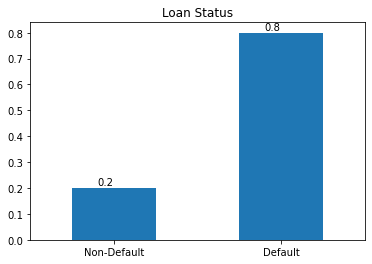

In [10]:
# Plot it as a bar chart
data.loan_status.value_counts(normalize=True).sort_values().plot(kind='bar')
plt.title('Loan Status')
# add Default instead of 1 and Non-Default instead of 0
plt.xticks([0, 1], ['Non-Default', 'Default'], rotation=0)
# show exact values
for i, v in enumerate(data.loan_status.value_counts(normalize=True).sort_values()):
    plt.text(i - 0.1, v + 0.01, str(round(v, 2)))
    
plt.show()

## Split the data into train and test sets

In [11]:
# Split the data into train and test (80-20 split)
# Use random_state = 42 to ensure that the results are reproducible
# Use stratify to ensure that the proportion of good and bad loans is the same in both train and test sets
X = data.drop(columns = 'loan_status')
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_test = X_train.copy(), X_test.copy()

In [12]:
X_train.shape, X_test.shape

((47081, 23), (11771, 23))

## Data Cleaning / Pre-processing

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_status           58852 non-null  int64         
 1   loan_amnt             58852 non-null  int64         
 2   term                  58852 non-null  int64         
 3   int_rate              58852 non-null  float64       
 4   installment           58852 non-null  float64       
 5   sub_grade             58852 non-null  object        
 6   emp_length            55510 non-null  float64       
 7   home_ownership        58852 non-null  object        
 8   annual_inc            58852 non-null  float64       
 9   verification_status   58852 non-null  object        
 10  issue_d               58852 non-null  datetime64[ns]
 11  purpose               58852 non-null  object        
 12  addr_state            58852 non-null  object        
 13  dti             

In [14]:
# emp_length
# Fill in the missing values with 0.
def emp_length_converter(df, column):
    df[column].fillna(value = 0, inplace = True)

# Apply to X_train
emp_length_converter(X_train, 'emp_length')

X_train['emp_length'].unique()
X_train['emp_length'].value_counts()

10.0    15618
0.0      6369
2.0      4293
3.0      3849
1.0      3036
5.0      2895
4.0      2831
6.0      2253
8.0      2126
7.0      2096
9.0      1715
Name: emp_length, dtype: int64

In [15]:
# issue_d

# Convert date columns to datetime format
# And create a new column as a difference between today and the respective date column
def date_converter(df, column):
    # store current month
    today_date = pd.to_datetime('2023-05-16')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_converter(X_train, 'issue_d')

# Check the new columns
print(X_train['mths_since_issue_d'].describe())



count    47081.000000
mean       100.959113
std         19.374397
min         64.000000
25%         88.000000
50%        100.000000
75%        112.000000
max        196.000000
Name: mths_since_issue_d, dtype: float64


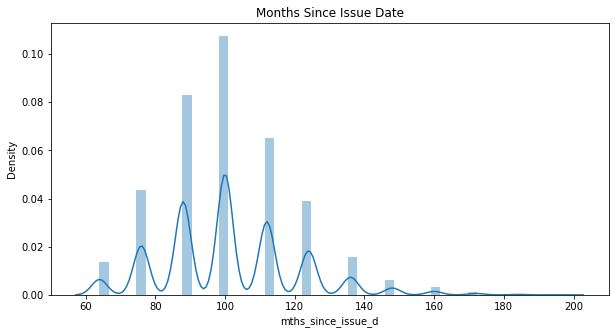

In [16]:
# Plot the distribution of the new column
plt.figure(figsize = (10, 5))
sns.distplot(X_train['mths_since_issue_d'])
plt.title('Months Since Issue Date')
plt.show()


In [17]:
# mort_acc column
X_train['mort_acc'].describe()

count    45450.000000
mean         1.683630
std          2.017776
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         24.000000
Name: mort_acc, dtype: float64

In [18]:
# mort_acc - fill in the missing values with 0
# It is better replace the empty values with 0 instead of the mean because the mean is 1.68.
def mort_acc_converter(df, column):
    df[column].fillna(value = 0, inplace = True)

mort_acc_converter(X_train, 'mort_acc')

In [19]:
# revol_util column - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
X_train['revol_util'].describe()

count    47057.000000
mean        52.001833
std         24.456244
min          0.000000
25%         33.700000
50%         52.500000
75%         70.800000
max        162.000000
Name: revol_util, dtype: float64

In [20]:
X_train['revol_util'].value_counts()

0.0      241
53.0     110
65.0     109
54.0     107
59.0     105
        ... 
162.0      1
102.2      1
106.1      1
123.9      1
109.5      1
Name: revol_util, Length: 1069, dtype: int64

In [21]:
# revol_util
# Fill in the missing values with the mean. Because the mean it is more representative than the median.
def revol_util_converter(df, column):
    df[column].fillna(value = df[column].mean(), inplace = True)

revol_util_converter(X_train, 'revol_util')

In [22]:
# pub_rec_bankruptcies
X_train['pub_rec_bankruptcies'].value_counts()

0.0    41200
1.0     5525
2.0      255
3.0       58
4.0       14
5.0        4
7.0        2
6.0        2
Name: pub_rec_bankruptcies, dtype: int64

In [23]:
# pub_rec_bankruptcies column: Number of public record bankruptcies
def pub_rec_bankruptcies_converter(df, column):
    df[column].fillna(value = 0, inplace = True)

pub_rec_bankruptcies_converter(X_train, 'pub_rec_bankruptcies')

## Feature Selection

In [24]:
# First divide training data into categorical and numerical subsets
X_train_num = X_train.select_dtypes(include = np.number).copy()
X_train_cat = X_train.select_dtypes(include = np.object).copy()

In [25]:
# initialize an empty dictionary to store the results of chi-square test
chi_sq_results = {}

# loop over all the categorical variables
for col in X_train_cat.columns:
    chi, pi, dof, expected = chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))

    chi_sq_results.setdefault('Feature', []).append(col)
    chi_sq_results.setdefault('p-value', []).append(round(pi, 10))


# convert the dictionary to a dataframe
chi_sq_results = pd.DataFrame(chi_sq_results)

# sort the dataframe by p_value
chi_sq_results.sort_values(by = 'p-value', ascending = True, ignore_index=True, inplace = True)

chi_sq_results


,Feature,p-value
0,sub_grade,0.0
1,home_ownership,0.0
2,verification_status,0.0
3,purpose,0.0
4,addr_state,0.0


None of the categorical variable seem to have predictive power

## ANOVA F-Statistic for numerical variables

In [26]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47081 entries, 40113 to 54711
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             47081 non-null  int64  
 1   term                  47081 non-null  int64  
 2   int_rate              47081 non-null  float64
 3   installment           47081 non-null  float64
 4   emp_length            47081 non-null  float64
 5   annual_inc            47081 non-null  float64
 6   dti                   47081 non-null  float64
 7   fico_range_low        47081 non-null  int64  
 8   fico_range_high       47081 non-null  int64  
 9   open_acc              47081 non-null  int64  
 10  pub_rec               47081 non-null  int64  
 11  revol_bal             47081 non-null  int64  
 12  revol_util            47081 non-null  float64
 13  mort_acc              47081 non-null  float64
 14  pub_rec_bankruptcies  47081 non-null  float64
 15  age            

In [27]:
# Since f_class_if does not accept missing values, wee will do a avery crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate the F Statistic and corresponding p value
f_stat, p_value = f_classif(X_train_num, y_train)

# Create a dataframe to store the results
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': f_stat, 'p values': p_value.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,int_rate,3151.639885,0.000000e+00
1,age,1452.585787,0.000000e+00
2,term,1413.446461,0.000000e+00
3,fico_range_low,836.414496,0.000000e+00
4,fico_range_high,836.405040,0.000000e+00
5,pay_status,633.958937,0.000000e+00
6,dti,570.765914,0.000000e+00
7,mort_acc,200.495962,0.000000e+00
8,loan_amnt,196.117426,0.000000e+00
9,revol_util,179.722477,0.000000e+00


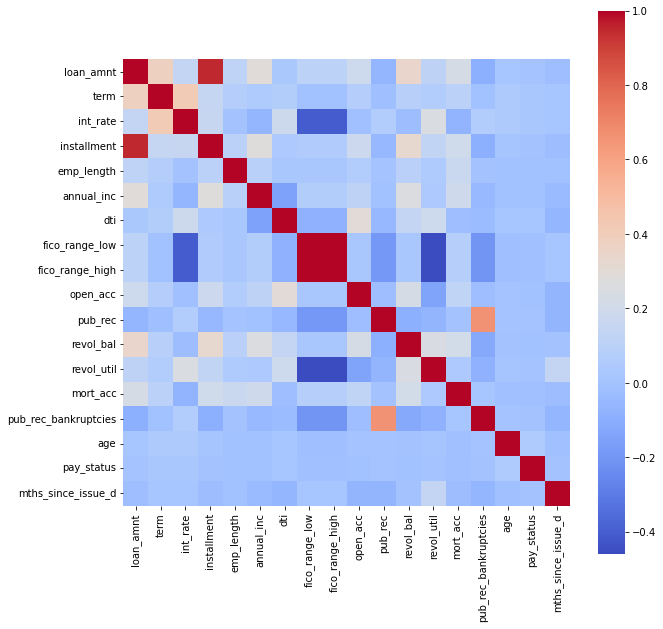

In [28]:
# Calculate the pair-wise correlations between the variables
corrmat = X_train_num.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');


- The ANOVA F-Statistic is used to identify the numerical variables that are most predictive of the target variable.
- Those columns are: 'pub_rec', 'emp_length', 'pub_rec_bankruptcies', 'open_acc', 'revol_bal'

In [29]:
# drop_columns_list = ['pub_rec', 'emp_length', 'pub_rec_bankruptcies', 'open_acc', 'revol_bal']

# def col_to_drop(df, column_list):
#     df.drop(columns = column_list, inplace = True)

# # apply to X_train
# col_to_drop(X_train, drop_columns_list)

## Creaty dummy variables for categorical variables

In [30]:
X_train_cat.columns

Index(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state'],
      dtype='object')

In [31]:
# def create_dummy(df, column_list):
#     '''
#     This function will create dummy variables for the categorical variables

#     df: the dataframe
#     column_list: list of categorical columns
#     '''
#     df_dummies = []
#     for col in column_list:
#         df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
#     df_dummies = pd.concat(df_dummies, axis = 1)
#     df = pd.concat([df, df_dummies], axis = 1)
#     return df

# # apply to X_train
# X_train = create_dummy(X_train, ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state'])


In [32]:
X_train.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status,mths_since_issue_d
18939,3000,36,7.35,93.12,A4,3.0,MORTGAGE,42000.0,Not Verified,other,PA,16.85,755,759,6,0,973,10.6,3.0,0.0,39,-2,64.0
50934,10175,36,12.12,338.54,B3,8.0,MORTGAGE,43000.0,Verified,debt_consolidation,NM,19.76,715,719,12,0,15931,75.1,1.0,0.0,26,0,124.0
39156,10000,36,13.11,337.47,B4,0.0,RENT,64700.0,Verified,debt_consolidation,TX,19.77,685,689,10,0,14331,77.3,0.0,0.0,36,2,136.0
18757,12000,36,6.49,367.74,A2,10.0,MORTGAGE,48000.0,Not Verified,debt_consolidation,MO,11.33,805,809,10,0,3614,7.4,2.0,0.0,29,0,100.0
2091,35000,60,15.80,847.42,C3,10.0,MORTGAGE,80000.0,Verified,debt_consolidation,CO,17.43,760,764,6,0,29935,89.4,5.0,0.0,35,0,124.0


## Update the test set

In [33]:
# Apply the same transformations to the test set
emp_length_converter(X_test, 'emp_length')
date_converter(X_test, 'issue_d')
mort_acc_converter(X_test, 'mort_acc')
revol_util_converter(X_test, 'revol_util')
pub_rec_bankruptcies_converter(X_test, 'pub_rec_bankruptcies')
# col_to_drop(X_test, drop_columns_list) # <<< I don't think this is necessary!

# X_test = create_dummy(X_test, ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']) # <<< I don't think this is necessary!

# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# Weight of Evidence (WoE) - Binning / Feature Engineering

- We will analyze both categorical and numerical features on their categorical/binned WoEs and IVs (Information Value) and then combine some of these binned categories together through a custom Python Class with fit_transform method.

In [34]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

## Analyze WoEs and IVs of discrete features

In [35]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


sns.set()
# Function for plotting WoE across categoris that takes 2 arguments: a dataframe and a number
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = 'dotted', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    


### 'sub_grade'

In [36]:
df = woe_discrete(X_train_prepr, 'sub_grade', y_train_prepr)
df

,sub_grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,A1,1604,0.034913,0.034069,56.0,1548.0,0.005947,0.041100,-1.933179,NaN,NaN,0.463088
1,A2,1254,0.053429,0.026635,67.0,1187.0,0.007115,0.031516,-1.488304,0.018516,0.444876,0.463088
2,A3,1338,0.053812,0.028419,72.0,1266.0,0.007646,0.033613,-1.480763,0.000383,0.007540,0.463088
3,A4,1889,0.076760,0.040122,145.0,1744.0,0.015398,0.046304,-1.101015,0.022949,0.379749,0.463088
4,A5,2340,0.084615,0.049702,198.0,2142.0,0.021026,0.056871,-0.995040,0.007855,0.105975,0.463088
5,B1,2514,0.103023,0.053397,259.0,2255.0,0.027503,0.059871,-0.777889,0.018408,0.217151,0.463088
6,B2,2566,0.121980,0.054502,313.0,2253.0,0.033238,0.059818,-0.587627,0.018957,0.190262,0.463088
7,B3,2944,0.138587,0.062531,408.0,2536.0,0.043326,0.067332,-0.440888,0.016607,0.146739,0.463088
8,B4,2846,0.162684,0.060449,463.0,2383.0,0.049166,0.063270,-0.252200,0.024098,0.188688,0.463088
9,B5,2910,0.171478,0.061808,499.0,2411.0,0.052989,0.064013,-0.189003,0.008793,0.063198,0.463088


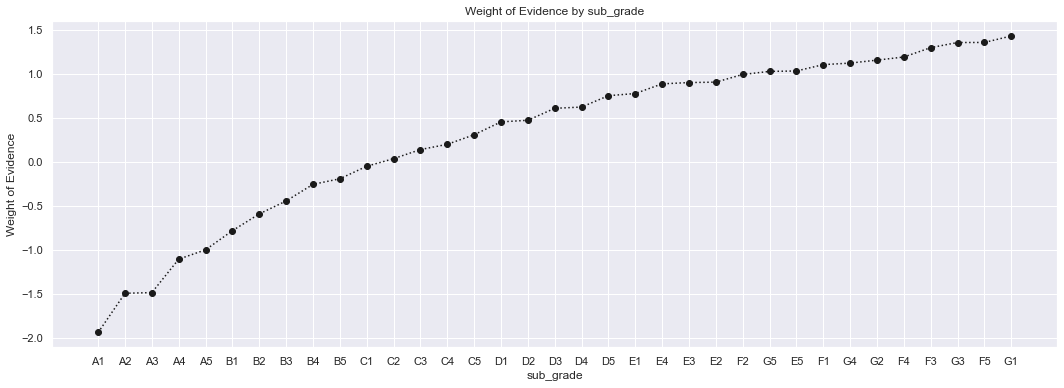

In [37]:
plot_by_woe(df)

In [38]:
# Combine sub_grades:
#  A1,A2,A3,A4,A5 as A
#  B1,B2,B3,B4,B5 as B etc
# Create a dictionary to map the sub_grades to the grades
sub_grade_dict = {'A1':'A', 'A2':'A', 'A3':'A', 'A4':'A', 'A5':'A',
                    'B1':'B', 'B2':'B', 'B3':'B', 'B4':'B', 'B5':'B',
                    'C1':'C', 'C2':'C', 'C3':'C', 'C4':'C', 'C5':'C',
                    'D1':'D', 'D2':'D', 'D3':'D', 'D4':'D', 'D5':'D',
                    'E1':'E', 'E2':'E', 'E3':'E', 'E4':'E', 'E5':'E',
                    'F1':'F', 'F2':'F', 'F3':'F', 'F4':'F', 'F5':'F',
                    'G1':'G', 'G2':'G', 'G3':'G', 'G4':'G', 'G5':'G'}


# Apply the dictionary to the sub_grade column
X_train_prepr['sub_grade'] = X_train_prepr['sub_grade'].map(sub_grade_dict)
X_test_prepr['sub_grade'] = X_test_prepr['sub_grade'].map(sub_grade_dict)

In [39]:
# Plot the WoE for the new sub_grade column
df = woe_discrete(X_train_prepr, 'sub_grade', y_train_prepr)
df

,sub_grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,A,8425,0.063858,0.178947,538.0,7887.0,0.057131,0.209404,-1.298924,NaN,NaN,0.429227
1,B,13780,0.140929,0.292687,1942.0,11838.0,0.206223,0.314305,-0.421408,0.077071,0.877516,0.429227
2,C,13090,0.220779,0.278031,2890.0,10200.0,0.306892,0.270816,0.125057,0.079850,0.546465,0.429227
3,D,7111,0.306005,0.151038,2176.0,4935.0,0.231071,0.131027,0.567324,0.085226,0.442267,0.429227
4,E,3232,0.378094,0.068648,1222.0,2010.0,0.129765,0.053367,0.888542,0.072089,0.321218,0.429227
5,F,1127,0.444543,0.023937,501.0,626.0,0.053202,0.016621,1.163444,0.066449,0.274902,0.429227
6,G,316,0.468354,0.006712,148.0,168.0,0.015716,0.004460,1.259436,0.023811,0.095993,0.429227


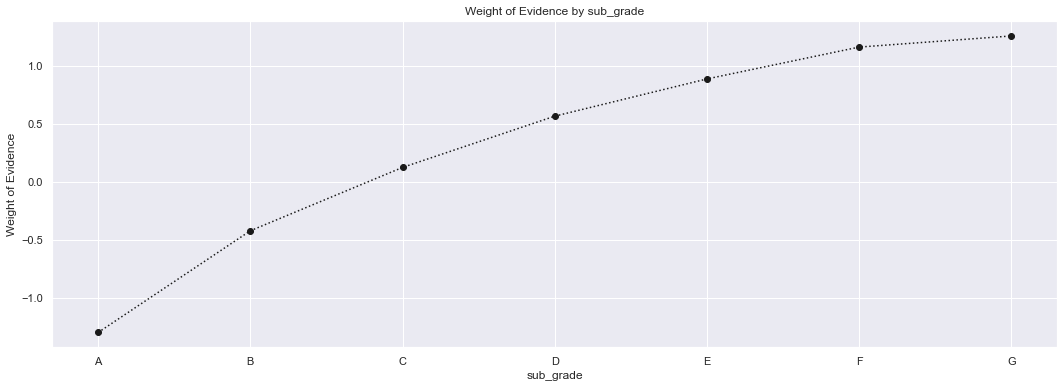

In [40]:
plot_by_woe(df)

We can see from the above graph that there is a continuous increase in WoE across the different grades. Therefore, we do not need to combine any features together and should leave all these 7 grades as they are

### home_ownership

In [41]:
df = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,ANY,8,0.125000,0.000170,1.0,7.0,0.000106,0.000186,-0.559722,NaN,NaN,0.030969
1,MORTGAGE,23216,0.173027,0.493108,4017.0,19199.0,0.426569,0.509744,-0.178135,0.048027,0.381587,0.030969
2,OWN,5098,0.203021,0.108281,1035.0,4063.0,0.109908,0.107875,0.018668,0.029994,0.196803,0.030969
3,RENT,18748,0.232505,0.398207,4359.0,14389.0,0.462886,0.382036,0.191967,0.029484,0.173299,0.030969
4,OTHER,8,0.375000,0.000170,3.0,5.0,0.000319,0.000133,0.875363,0.142495,0.683396,0.030969
5,NONE,3,0.666667,0.000064,2.0,1.0,0.000212,0.000027,2.079335,0.291667,1.203973,0.030969


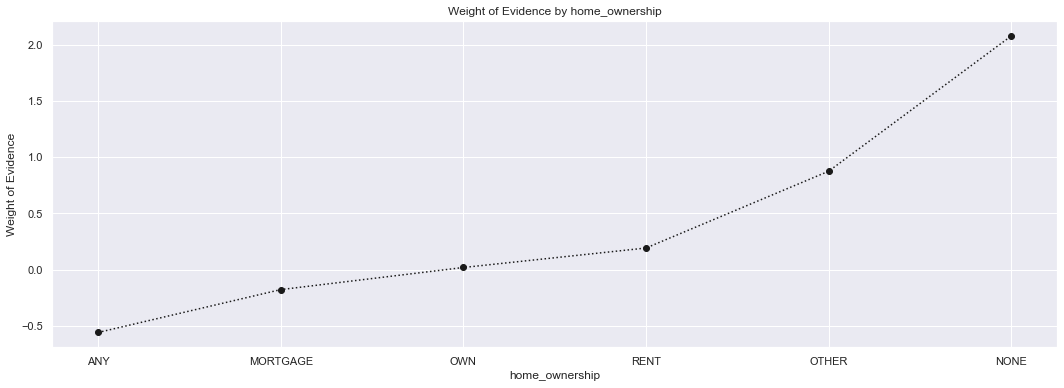

In [42]:
plot_by_woe(df)

### verification_status 

In [43]:
df = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Not Verified,14247,0.147821,0.302606,2106.0,12141.0,0.223638,0.322350,-0.365610,NaN,NaN,0.053058
1,Source Verified,18428,0.211960,0.391411,3906.0,14522.0,0.414782,0.385567,0.073037,0.064139,0.438647,0.053058
2,Verified,14406,0.236360,0.305983,3405.0,11001.0,0.361580,0.292083,0.213447,0.024400,0.140410,0.053058


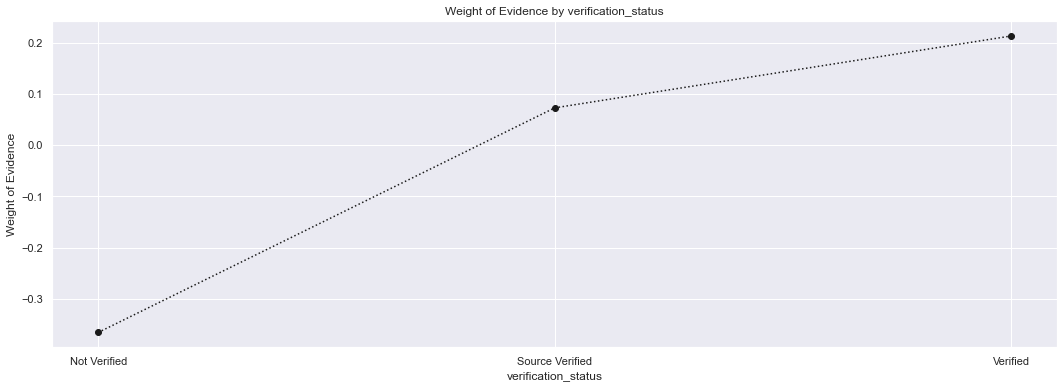

In [44]:
plot_by_woe(df)

### purpose

In [45]:
df = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)
df

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,wedding,75,0.120000,0.001593,9.0,66.0,0.000956,0.001752,-0.606242,NaN,NaN,0.016402
1,car,496,0.163306,0.010535,81.0,415.0,0.008601,0.011018,-0.247641,0.043306,0.358601,0.016402
2,educational,12,0.166667,0.000255,2.0,10.0,0.000212,0.000266,-0.223250,0.003360,0.024391,0.016402
3,credit_card,10465,0.170760,0.222277,1787.0,8678.0,0.189763,0.230406,-0.194065,0.004093,0.029185,0.016402
4,vacation,339,0.174041,0.007200,59.0,280.0,0.006265,0.007434,-0.171064,0.003282,0.023001,0.016402
5,renewable_energy,34,0.176471,0.000722,6.0,28.0,0.000637,0.000743,-0.154257,0.002429,0.016807,0.016402
6,house,255,0.184314,0.005416,47.0,208.0,0.004991,0.005523,-0.101202,0.007843,0.053055,0.016402
7,major_purchase,1013,0.188549,0.021516,191.0,822.0,0.020282,0.021825,-0.073279,0.004235,0.027924,0.016402
8,home_improvement,2956,0.195196,0.062785,577.0,2379.0,0.061272,0.063164,-0.030405,0.006647,0.042874,0.016402
9,other,2745,0.199636,0.058304,548.0,2197.0,0.058193,0.058332,-0.002385,0.004439,0.028020,0.016402


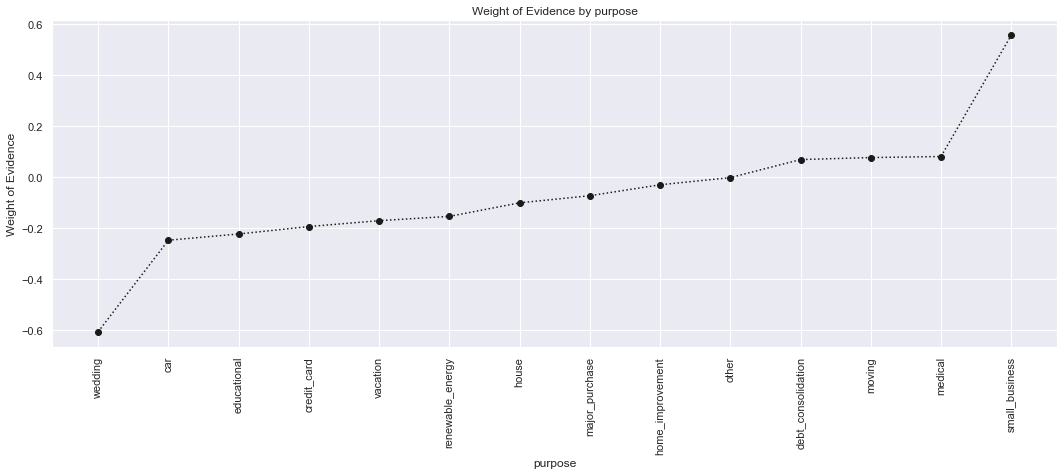

In [46]:
plot_by_woe(df, 90)

### addr_state

In [47]:
df = woe_discrete(X_train_prepr, 'addr_state', y_train_prepr)
df

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,IA,1,0.000000,0.000021,0.0,1.0,0.000000,0.000027,-inf,NaN,NaN,inf
1,VT,88,0.079545,0.001869,7.0,81.0,0.000743,0.002151,-1.062351,0.079545,inf,inf
2,OR,592,0.116554,0.012574,69.0,523.0,0.007327,0.013886,-0.639287,0.037009,0.423064,inf
3,DC,142,0.119718,0.003016,17.0,125.0,0.001805,0.003319,-0.608912,0.003164,0.030375,inf
4,ME,47,0.127660,0.000998,6.0,41.0,0.000637,0.001089,-0.535624,0.007941,0.073288,inf
5,RI,205,0.141463,0.004354,29.0,176.0,0.003080,0.004673,-0.417000,0.013804,0.118624,inf
6,SC,540,0.144444,0.011470,78.0,462.0,0.008283,0.012266,-0.392668,0.002981,0.024332,inf
7,WY,99,0.151515,0.002103,15.0,84.0,0.001593,0.002230,-0.336578,0.007071,0.056089,inf
8,NH,226,0.154867,0.004800,35.0,191.0,0.003717,0.005071,-0.310737,0.003352,0.025841,inf
9,ID,56,0.160714,0.001189,9.0,47.0,0.000956,0.001248,-0.266735,0.005847,0.044002,inf


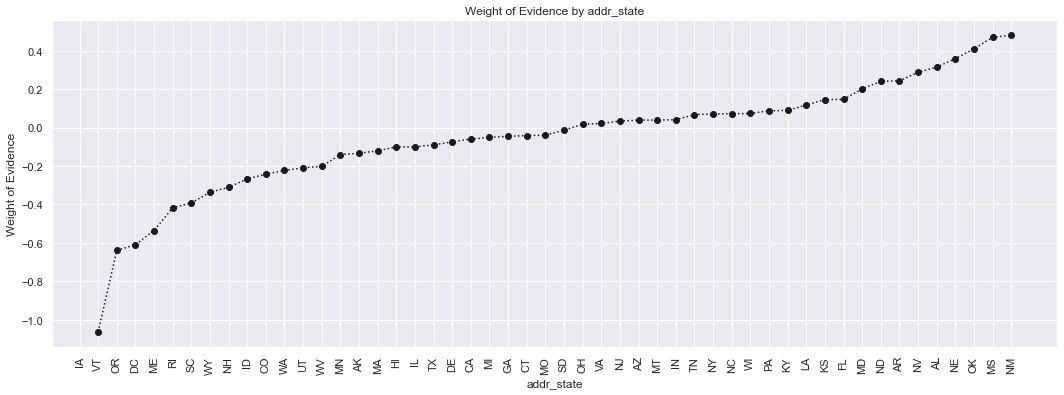

In [48]:
plot_by_woe(df, 90)

### Analyze WoEs and IVs of numeric features

In [49]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [59]:
X_train_prepr['loan_amnt_factor'] = pd.cut(X_train_prepr['loan_amnt'], 10)
df = woe_ordered_continuous(X_train_prepr, 'loan_amnt_factor', y_train_prepr)
df

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(961.0, 4900.0]",4652,0.158856,0.098808,739.0,3913.0,0.078475,0.103892,-0.280574,NaN,NaN,0.032332
1,"(4900.0, 8800.0]",9792,0.166565,0.207982,1631.0,8161.0,0.173197,0.216679,-0.223985,0.007708,0.056588,0.032332
2,"(8800.0, 12700.0]",10304,0.192352,0.218857,1982.0,8322.0,0.210470,0.220954,-0.048608,0.025788,0.175377,0.032332
3,"(12700.0, 16600.0]",6899,0.216698,0.146535,1495.0,5404.0,0.158755,0.143479,0.101175,0.024346,0.149783,0.032332
4,"(16600.0, 20500.0]",5657,0.223086,0.120155,1262.0,4395.0,0.134013,0.116690,0.138418,0.006388,0.037243,0.032332
5,"(20500.0, 24400.0]",3106,0.241790,0.065971,751.0,2355.0,0.079749,0.062527,0.243298,0.018704,0.104879,0.032332
6,"(24400.0, 28300.0]",2735,0.227788,0.058091,623.0,2112.0,0.066157,0.056075,0.165344,0.014002,0.077954,0.032332
7,"(28300.0, 32200.0]",1621,0.246761,0.034430,400.0,1221.0,0.042476,0.032418,0.270227,0.018973,0.104883,0.032332
8,"(32200.0, 36100.0]",2096,0.237118,0.044519,497.0,1599.0,0.052777,0.042454,0.217644,0.009643,0.052583,0.032332
9,"(36100.0, 40000.0]",219,0.168950,0.004652,37.0,182.0,0.003929,0.004832,-0.206901,0.068169,0.424545,0.032332


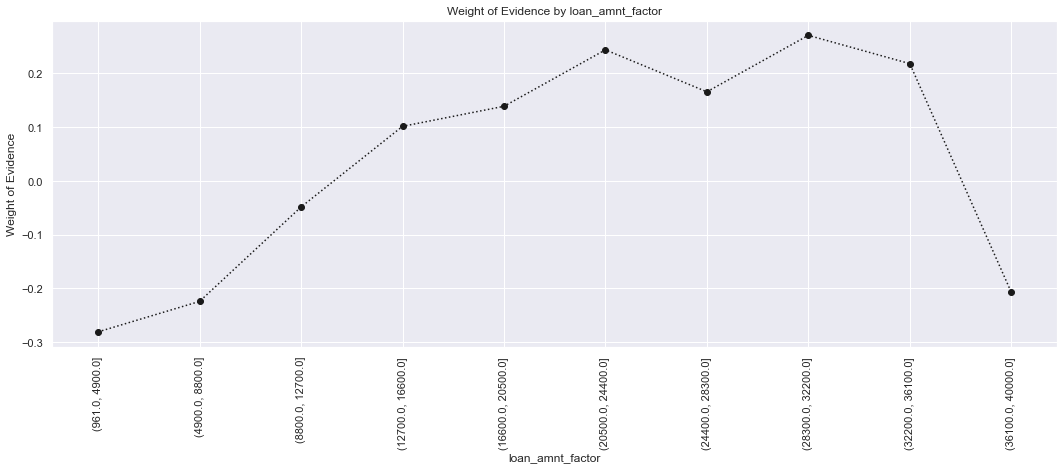

In [62]:
plot_by_woe(df, 90)

In [63]:
df = woe_ordered_continuous(X_train_prepr, 'term', y_train_prepr)
df

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,36014,0.162159,0.764937,5840.0,30174.0,0.620155,0.801136,-0.256062,NaN,NaN,0.163463
1,60,11067,0.323213,0.235063,3577.0,7490.0,0.379845,0.198864,0.647144,0.161054,0.903205,0.163463


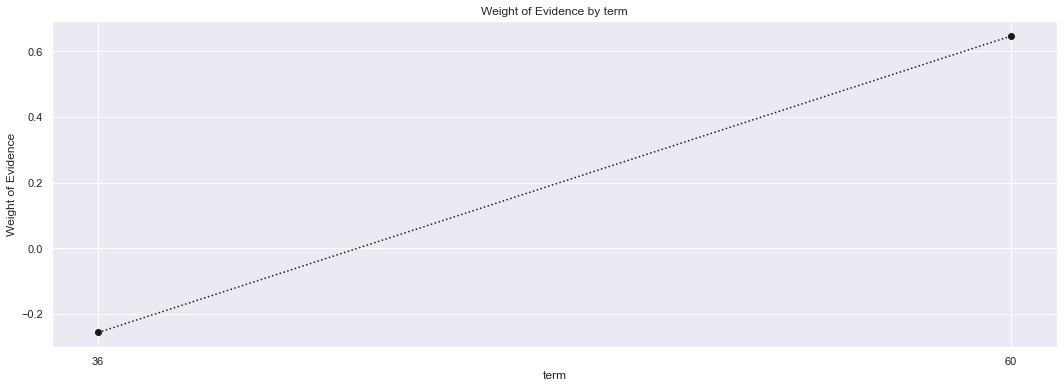

In [64]:
plot_by_woe(df)

In [67]:
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 10)

df = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.284, 7.878]",5627,0.054558,0.119517,307.0,5320.0,0.032601,0.141249,-1.466193,NaN,NaN,0.416978
1,"(7.878, 10.446]",8459,0.110533,0.179669,935.0,7524.0,0.099289,0.199766,-0.699118,0.055975,0.767074,0.416978
2,"(10.446, 13.014]",10952,0.171110,0.232620,1874.0,9078.0,0.199002,0.241026,-0.191591,0.060577,0.507528,0.416978
3,"(13.014, 15.582]",8592,0.218575,0.182494,1878.0,6714.0,0.199427,0.178260,0.112201,0.047465,0.303791,0.416978
4,"(15.582, 18.15]",6447,0.282147,0.136934,1819.0,4628.0,0.193161,0.122876,0.452350,0.063571,0.340150,0.416978
5,"(18.15, 20.718]",3682,0.336230,0.078206,1238.0,2444.0,0.131464,0.064890,0.706049,0.054084,0.253699,0.416978
6,"(20.718, 23.286]",1628,0.389435,0.034579,634.0,994.0,0.067325,0.026391,0.936500,0.053205,0.230451,0.416978
7,"(23.286, 25.854]",1083,0.399815,0.023003,433.0,650.0,0.045981,0.017258,0.979954,0.010380,0.043454,0.416978
8,"(25.854, 28.422]",328,0.466463,0.006967,153.0,175.0,0.016247,0.004646,1.251840,0.066648,0.271887,0.416978
9,"(28.422, 30.99]",283,0.515901,0.006011,146.0,137.0,0.015504,0.003637,1.449814,0.049438,0.197974,0.416978


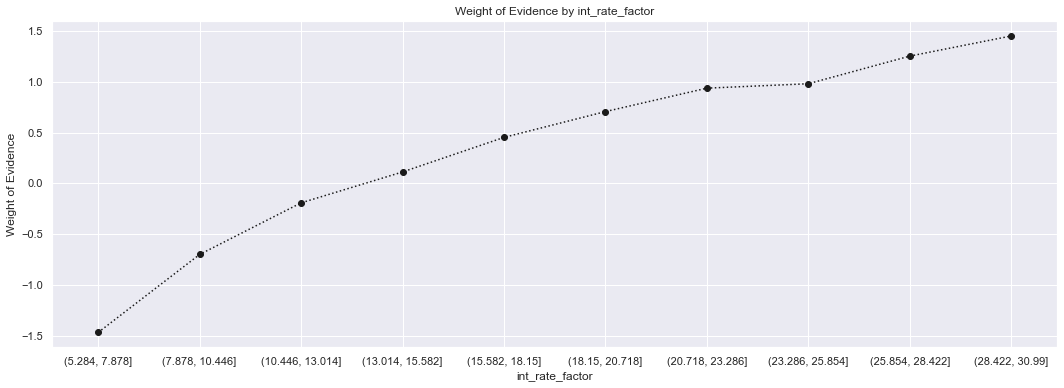

In [68]:
plot_by_woe(df)

In [76]:
X_train_prepr['installment_factor'] = pd.cut(X_train_prepr['installment'], 10)

df = woe_ordered_continuous(X_train_prepr, 'installment_factor', y_train_prepr)
df


,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(29.224, 179.348]",6636,0.154008,0.140949,1022.0,5614.0,0.108527,0.149055,-0.317314,NaN,NaN,0.031519
1,"(179.348, 327.986]",12768,0.178102,0.271192,2274.0,10494.0,0.241478,0.278621,-0.143075,0.024093,0.174239,0.031519
2,"(327.986, 476.624]",10703,0.221994,0.227332,2376.0,8327.0,0.252310,0.221086,0.132103,0.043892,0.275178,0.031519
3,"(476.624, 625.262]",7167,0.222827,0.152227,1597.0,5570.0,0.169587,0.147887,0.136920,0.000833,0.004817,0.031519
4,"(625.262, 773.9]",4445,0.213723,0.094412,950.0,3495.0,0.100881,0.092794,0.083561,0.009104,0.053358,0.031519
5,"(773.9, 922.538]",2659,0.222640,0.056477,592.0,2067.0,0.062865,0.054880,0.135841,0.008917,0.052280,0.031519
6,"(922.538, 1071.176]",1235,0.242105,0.026231,299.0,936.0,0.031751,0.024851,0.245016,0.019465,0.109175,0.031519
7,"(1071.176, 1219.814]",1021,0.182174,0.021686,186.0,835.0,0.019752,0.022170,-0.115497,0.059931,0.360513,0.031519
8,"(1219.814, 1368.452]",419,0.255370,0.008900,107.0,312.0,0.011362,0.008284,0.316014,0.073196,0.431511,0.031519
9,"(1368.452, 1517.09]",28,0.500000,0.000595,14.0,14.0,0.001487,0.000372,1.386188,0.244630,1.070174,0.031519


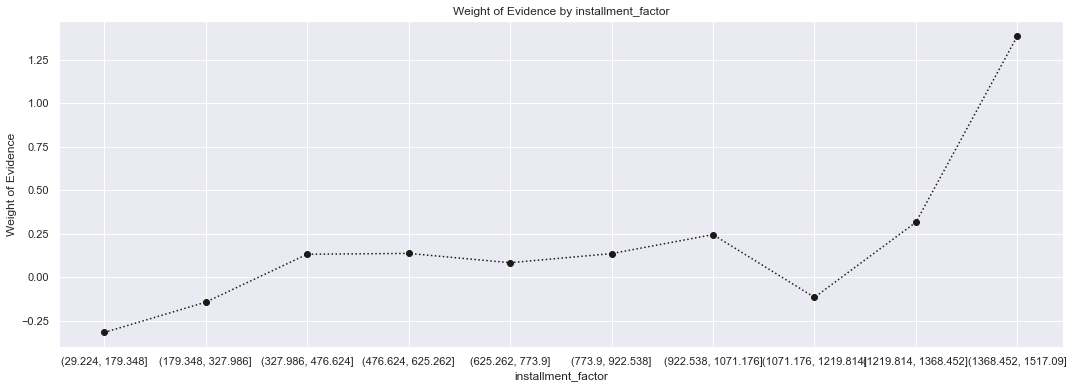

In [77]:
plot_by_woe(df)

In [89]:
X_train_prepr['annual_inc_factor'] = pd.cut(X_train_prepr['annual_inc'], 50)
# 
df = woe_ordered_continuous(X_train_prepr, 'annual_inc_factor', y_train_prepr)
df

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-297.026, 146535.52]",44111,0.203260,0.936917,8966.0,35145.0,0.952108,0.933119,0.020145,NaN,NaN,inf
1,"(146535.52, 286376.04]",2615,0.157170,0.055543,411.0,2204.0,0.043644,0.058517,-0.293248,0.046090,0.313393,inf
2,"(286376.04, 426216.56]",253,0.118577,0.005374,30.0,223.0,0.003186,0.005921,-0.619786,0.038593,0.326538,inf
3,"(426216.56, 566057.08]",50,0.100000,0.001062,5.0,45.0,0.000531,0.001195,-0.811036,0.018577,0.191250,inf
4,"(566057.08, 705897.6]",21,0.095238,0.000446,2.0,19.0,0.000212,0.000504,-0.865104,0.004762,0.054067,inf
5,"(705897.6, 845738.12]",9,0.000000,0.000191,0.0,9.0,0.000000,0.000239,-inf,0.095238,inf,inf
6,"(845738.12, 985578.64]",10,0.100000,0.000212,1.0,9.0,0.000106,0.000239,-0.811036,0.100000,inf,inf
7,"(985578.64, 1125419.16]",4,0.250000,0.000085,1.0,3.0,0.000106,0.000080,0.287576,0.150000,1.098612,inf
8,"(1125419.16, 1265259.68]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(1265259.68, 1405100.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


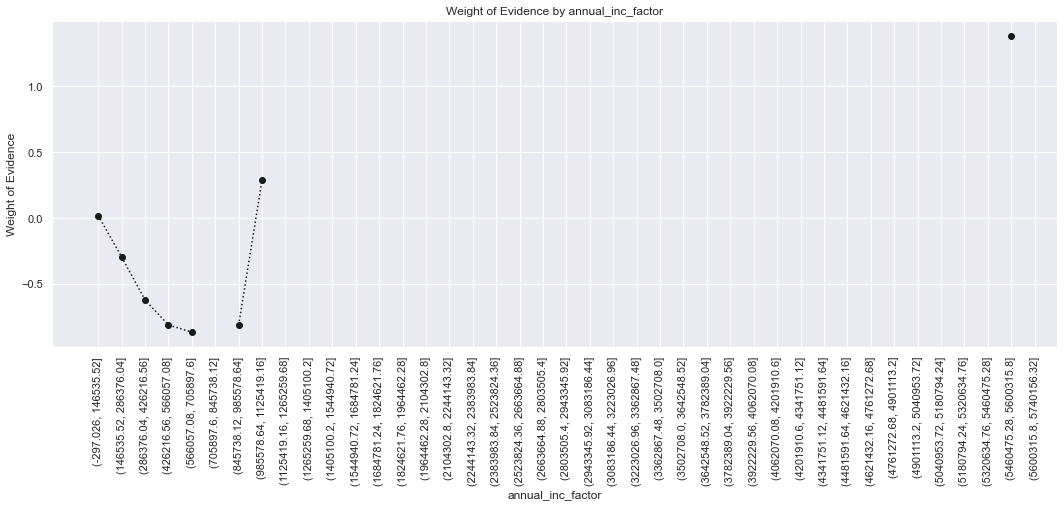

In [90]:
plot_by_woe(df, 90)

In [93]:
# dti
X_train_prepr['dti_factor'] = pd.cut(X_train_prepr['dti'], 5)
df = woe_ordered_continuous(X_train_prepr, 'dti_factor', y_train_prepr)
df

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.0499, 9.988]",8626,0.149664,0.183216,1291.0,7335.0,0.137092,0.194748,-0.351052,NaN,NaN,0.071145
1,"(9.988, 19.976]",19993,0.177012,0.424651,3539.0,16454.0,0.375810,0.436863,-0.150536,0.027348,0.200516,0.071145
2,"(19.976, 29.964]",14272,0.234375,0.303137,3345.0,10927.0,0.355209,0.290118,0.202418,0.057363,0.352954,0.071145
3,"(29.964, 39.952]",4129,0.294502,0.087700,1216.0,2913.0,0.129128,0.077342,0.512571,0.060127,0.310153,0.071145
4,"(39.952, 49.94]",61,0.426230,0.001296,26.0,35.0,0.002761,0.000929,1.088937,0.131727,0.576365,0.071145


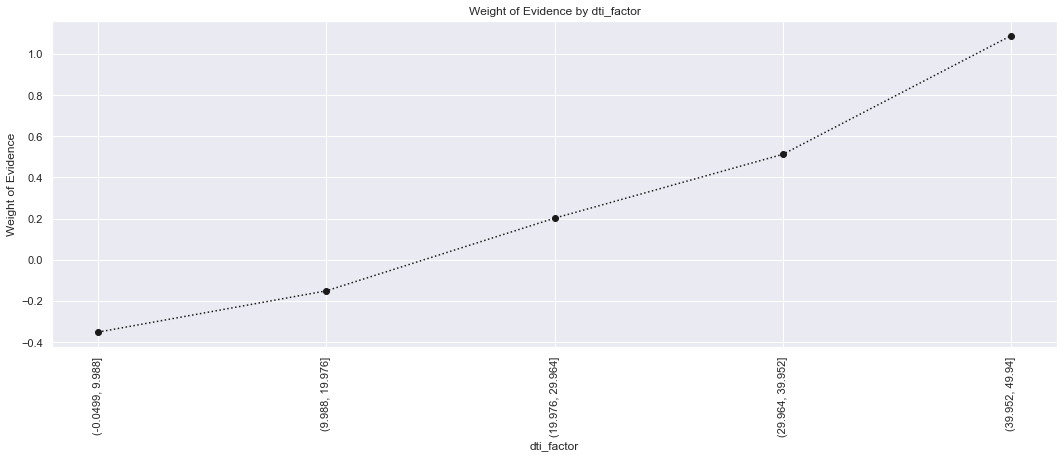

In [94]:
plot_by_woe(df, 90)

In [109]:
# fico_range_low and fico_range_high
X_train_prepr['fico_range_low_factor'] = pd.cut(X_train_prepr['fico_range_low'], 20)
df = woe_ordered_continuous(X_train_prepr, 'fico_range_low_factor', y_train_prepr)
df

,fico_range_low_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(659.815, 669.25]",8355,0.263315,0.177460,2200.0,6155.0,0.233620,0.163419,0.357381,NaN,NaN,0.131576
1,"(669.25, 678.5]",7819,0.240952,0.166075,1884.0,5935.0,0.200064,0.157578,0.238718,0.022364,0.118662,0.131576
2,"(678.5, 687.75]",6806,0.231120,0.144559,1573.0,5233.0,0.167038,0.138939,0.184188,0.009832,0.054530,0.131576
3,"(687.75, 697.0]",5898,0.197185,0.125273,1163.0,4735.0,0.123500,0.125717,-0.017791,0.033934,0.201979,0.131576
4,"(697.0, 706.25]",4803,0.177181,0.102016,851.0,3952.0,0.090368,0.104928,-0.149377,0.020005,0.131586,0.131576
5,"(706.25, 715.5]",3744,0.158654,0.079523,594.0,3150.0,0.063077,0.083634,-0.282090,0.018527,0.132713,0.131576
6,"(715.5, 724.75]",1537,0.148992,0.032646,229.0,1308.0,0.024318,0.034728,-0.356344,0.009662,0.074254,0.131576
7,"(724.75, 734.0]",2313,0.142240,0.049128,329.0,1984.0,0.034937,0.052676,-0.410624,0.006752,0.054280,0.131576
8,"(734.0, 743.25]",1584,0.132576,0.033644,210.0,1374.0,0.022300,0.036480,-0.492186,0.009664,0.081561,0.131576
9,"(743.25, 752.5]",1171,0.117848,0.024872,138.0,1033.0,0.014654,0.027427,-0.626781,0.014728,0.134595,0.131576


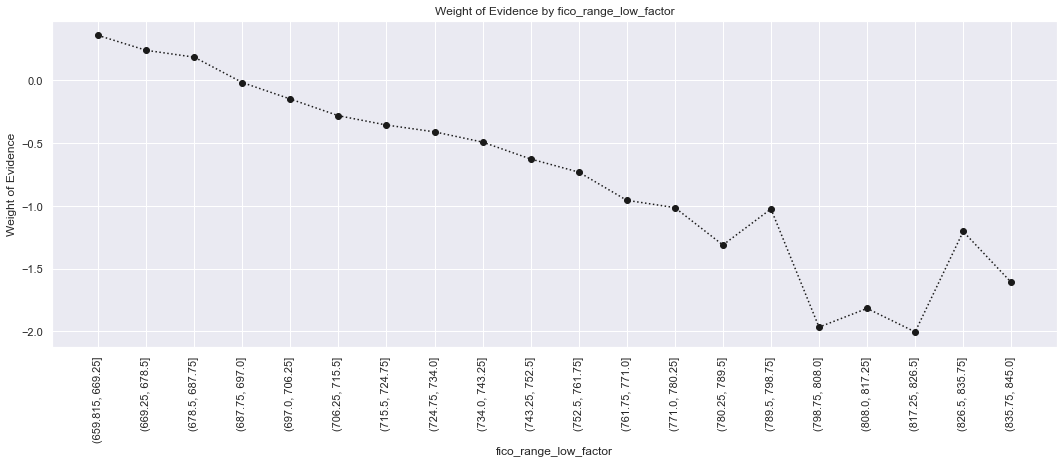

In [110]:
plot_by_woe(df, 90)

In [117]:
# fico_range_low and fico_range_high
X_train_prepr['fico_range_high_factor'] = pd.cut(X_train_prepr['fico_range_high'], 20)
df = woe_ordered_continuous(X_train_prepr, 'fico_range_high_factor', y_train_prepr)
df

,fico_range_high_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(663.814, 673.3]",8355,0.263315,0.177460,2200.0,6155.0,0.233620,0.163419,0.357381,NaN,NaN,0.131919
1,"(673.3, 682.6]",7819,0.240952,0.166075,1884.0,5935.0,0.200064,0.157578,0.238718,0.022364,0.118662,0.131919
2,"(682.6, 691.9]",6806,0.231120,0.144559,1573.0,5233.0,0.167038,0.138939,0.184188,0.009832,0.054530,0.131919
3,"(691.9, 701.2]",5898,0.197185,0.125273,1163.0,4735.0,0.123500,0.125717,-0.017791,0.033934,0.201979,0.131919
4,"(701.2, 710.5]",4803,0.177181,0.102016,851.0,3952.0,0.090368,0.104928,-0.149377,0.020005,0.131586,0.131919
5,"(710.5, 719.8]",3744,0.158654,0.079523,594.0,3150.0,0.063077,0.083634,-0.282090,0.018527,0.132713,0.131919
6,"(719.8, 729.1]",2790,0.150179,0.059260,419.0,2371.0,0.044494,0.062951,-0.347008,0.008475,0.064918,0.131919
7,"(729.1, 738.4]",1060,0.131132,0.022514,139.0,921.0,0.014761,0.024453,-0.504798,0.019047,0.157790,0.131919
8,"(738.4, 747.7]",1584,0.132576,0.033644,210.0,1374.0,0.022300,0.036480,-0.492186,0.001444,0.012612,0.131919
9,"(747.7, 757.0]",1171,0.117848,0.024872,138.0,1033.0,0.014654,0.027427,-0.626781,0.014728,0.134595,0.131919


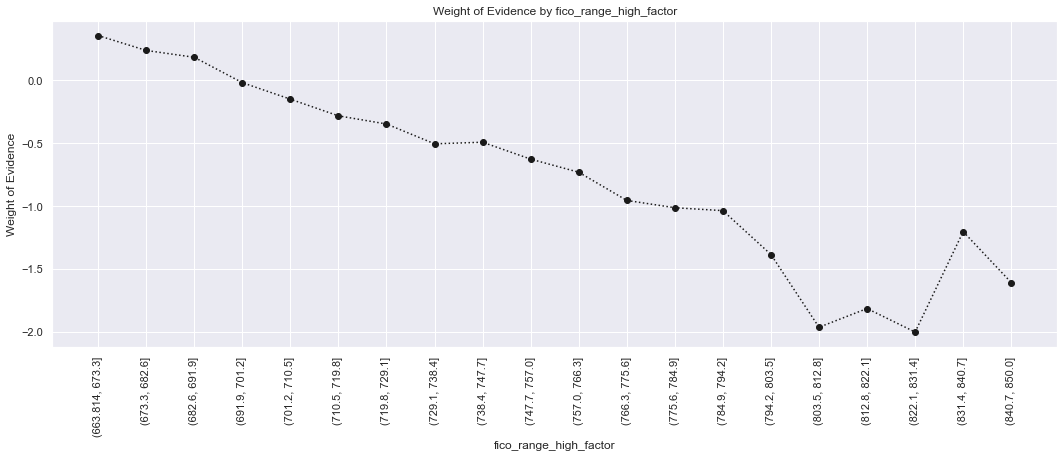

In [118]:
plot_by_woe(df, 90)

In [125]:
X_train_prepr['mort_acc_factor'] = pd.cut(X_train_prepr['mort_acc'], 30)
df = woe_ordered_continuous(X_train_prepr, 'mort_acc_factor', y_train_prepr)
df


,mort_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.024, 0.8]",19948,0.226840,0.423695,4525.0,15423.0,0.480514,0.409489,0.159946,NaN,NaN,inf
1,"(0.8, 1.6]",7887,0.206796,0.167520,1631.0,6256.0,0.173197,0.166100,0.041840,0.020044,0.118105,inf
2,"(1.6, 2.4]",6615,0.182615,0.140503,1208.0,5407.0,0.128279,0.143559,-0.112540,0.024181,0.154381,inf
3,"(2.4, 3.2]",4874,0.174395,0.103524,850.0,4024.0,0.090262,0.106839,-0.168607,0.008221,0.056067,inf
4,"(3.2, 4.0]",3280,0.159146,0.069667,522.0,2758.0,0.055432,0.073226,-0.278405,0.015248,0.109798,inf
5,"(4.0, 4.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(4.8, 5.6]",2010,0.157711,0.042692,317.0,1693.0,0.033663,0.044950,-0.289167,NaN,NaN,inf
7,"(5.6, 6.4]",1177,0.154630,0.024999,182.0,995.0,0.019327,0.026418,-0.312548,0.003081,0.023380,inf
8,"(6.4, 7.2]",618,0.137540,0.013126,85.0,533.0,0.009026,0.014151,-0.449682,0.017090,0.137134,inf
9,"(7.2, 8.0]",310,0.138710,0.006584,43.0,267.0,0.004566,0.007089,-0.439860,0.001169,0.009822,inf


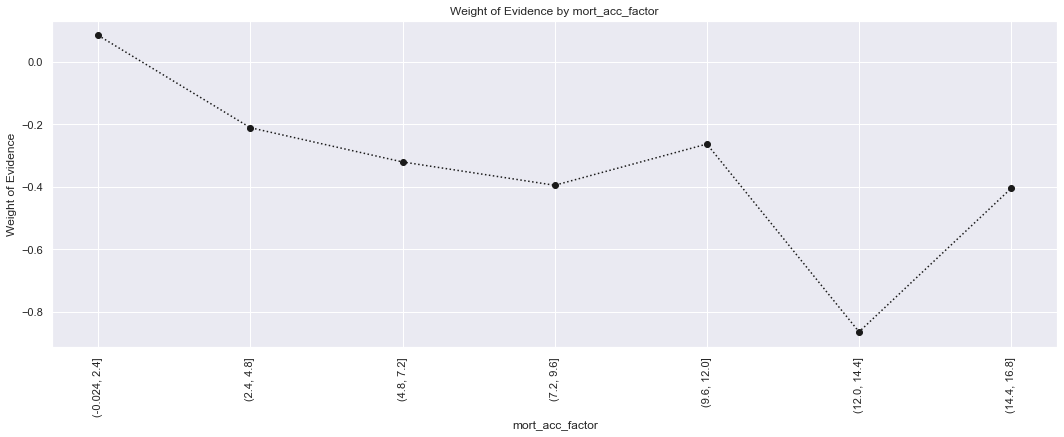

In [124]:
plot_by_woe(df, 90)

In [147]:
# X_train_prepr['age'].describe()

In [132]:
X_train_prepr['age_factor'] = pd.cut(X_train_prepr['age'], 10)
df = woe_ordered_continuous(X_train_prepr, 'age_factor', y_train_prepr)
df

,age_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(19.942, 25.8]",6652,0.029465,0.141288,196.0,6456.0,0.020813,0.171410,-2.108462,NaN,NaN,0.392806
1,"(25.8, 31.6]",12715,0.180024,0.270066,2289.0,10426.0,0.243071,0.276816,-0.129999,0.150559,1.978463,0.392806
2,"(31.6, 37.4]",10604,0.228404,0.225229,2422.0,8182.0,0.257194,0.217237,0.168845,0.048381,0.298845,0.392806
3,"(37.4, 43.2]",7920,0.241540,0.168221,1913.0,6007.0,0.203143,0.159489,0.241935,0.013136,0.073090,0.392806
4,"(43.2, 49.0]",5093,0.262910,0.108175,1339.0,3754.0,0.142190,0.099671,0.355289,0.021369,0.113354,0.392806
5,"(49.0, 54.8]",2472,0.271845,0.052505,672.0,1800.0,0.071360,0.047791,0.400905,0.008935,0.045615,0.392806
6,"(54.8, 60.6]",1189,0.342304,0.025254,407.0,782.0,0.043220,0.020763,0.733147,0.070460,0.332242,0.392806
7,"(60.6, 66.4]",333,0.405405,0.007073,135.0,198.0,0.014336,0.005257,1.003196,0.063101,0.270049,0.392806
8,"(66.4, 72.2]",91,0.439560,0.001933,40.0,51.0,0.004248,0.001354,1.143242,0.034155,0.140046,0.392806
9,"(72.2, 78.0]",12,0.333333,0.000255,4.0,8.0,0.000425,0.000212,0.693041,0.106227,0.450201,0.392806


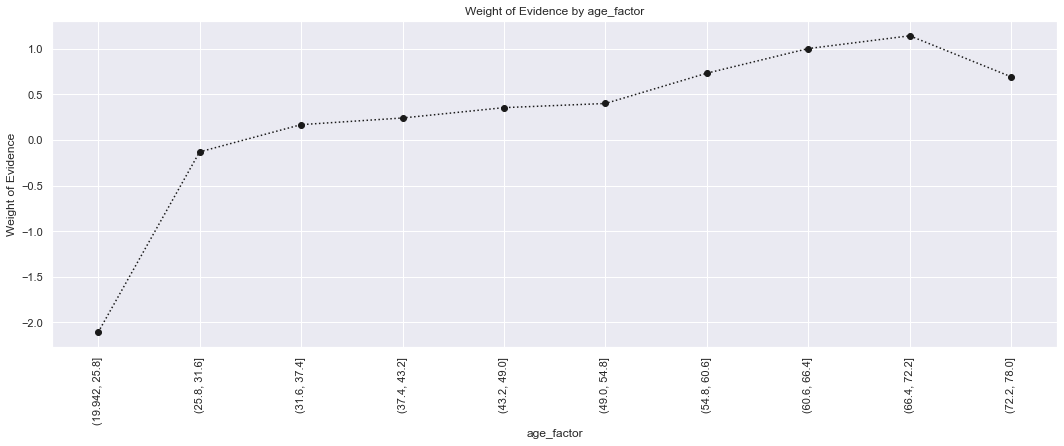

In [133]:
plot_by_woe(df, 90)

In [142]:
X_train_prepr['pay_status_factor'] = pd.cut(X_train_prepr['pay_status'], 5)
df = woe_ordered_continuous(X_train_prepr, 'pay_status_factor', y_train_prepr)
df

,pay_status_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2.011, 0.2]",34965,0.168454,0.742656,5890.0,29075.0,0.625465,0.771957,-0.210435,NaN,NaN,0.110484
1,"(0.2, 2.4]",11166,0.282823,0.237166,3158.0,8008.0,0.335351,0.212617,0.455686,0.114369,0.666121,0.110484
2,"(2.4, 4.6]",846,0.407801,0.017969,345.0,501.0,0.036636,0.013302,1.013126,0.124979,0.557440,0.110484
3,"(4.6, 6.8]",59,0.220339,0.001253,13.0,46.0,0.001380,0.001221,0.122496,0.187462,0.890630,0.110484
4,"(6.8, 9.0]",45,0.244444,0.000956,11.0,34.0,0.001168,0.000903,0.257723,0.024105,0.135227,0.110484


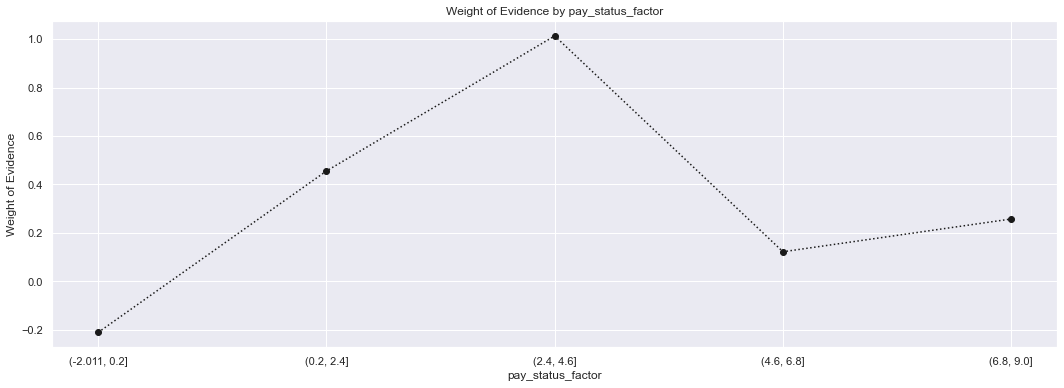

In [144]:
plot_by_woe(df)

# Define Custom Class from WoE Binning and Feature Engineering

In [ ]:
ref_categories = ['verification_status:Not Verified', 
                  'purpose:debt_consolidation', 
                  'home_ownership:RENT', 
                  'sub_grade:G4', 
                  'addr_state:ND', 
                  'term:36 months', 
                  'int_rate_factor:(5.312, 8.948]', 
                  'installment_factor:(20.088, 40.176]', 
                  'annual_inc_factor:(20000.0, 100000.0]', 
                  'dti_factor:(0.716, 3.584]', 
                  'fico_range_low:(664.0, 688.0]', 
                  'fico_range_high:(668.0, 692.0]', 
                  'mort_acc:(0.0, 1.0]', 
                  'age:(0.999, 6.0]', 
                  'pay_status:(0.999, 6.0]']

class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X):
        self.X = X
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X_new = X.loc[:, 'sub_grade:A1':'sub_grade:G5']
        # Term
        X_new['term:36 months'] = np.where(X['term'].isin([' 36 months']), 1, 0)
        X_new['term:60 months'] = np.where(X['term'].isin([' 60 months']), 1, 0)

        # Grade
        X_new['sub_grade:G4'] = np.where(X['sub_grade'].isin(['G4']), 1, 0)
        X_new['sub_grade:G5'] = np.where(X['sub_grade'].isin(['G5']), 1, 0)
        X_new['sub_grade:G3'] = np.where(X['sub_grade'].isin(['G3']), 1, 0)
        X_new['sub_grade:G2'] = np.where(X['sub_grade'].isin(['G2']), 1, 0)
        X_new['sub_grade:G1'] = np.where(X['sub_grade'].isin(['G1']), 1, 0)
        X_new['sub_grade:F5'] = np.where(X['sub_grade'].isin(['F5']), 1, 0)
        X_new['sub_grade:F4'] = np.where(X['sub_grade'].isin(['F4']), 1, 0)
        X_new['sub_grade:F3'] = np.where(X['sub_grade'].isin(['F3']), 1, 0)
        X_new['sub_grade:F2'] = np.where(X['sub_grade'].isin(['F2']), 1, 0)
        X_new['sub_grade:F1'] = np.where(X['sub_grade'].isin(['F1']), 1, 0)
        X_new['sub_grade:E5'] = np.where(X['sub_grade'].isin(['E5']), 1, 0)
        X_new['sub_grade:E4'] = np.where(X['sub_grade'].isin(['E4']), 1, 0)
        X_new['sub_grade:E3'] = np.where(X['sub_grade'].isin(['E3']), 1, 0)
        X_new['sub_grade:E2'] = np.where(X['sub_grade'].isin(['E2']), 1, 0)
        X_new['sub_grade:E1'] = np.where(X['sub_grade'].isin(['E1']), 1, 0)
        X_new['sub_grade:D5'] = np.where(X['sub_grade'].isin(['D5']), 1, 0)
        X_new['sub_grade:D4'] = np.where(X['sub_grade'].isin(['D4']), 1, 0)
        X_new['sub_grade:D3'] = np.where(X['sub_grade'].isin(['D3']), 1, 0)

        # State
        X_new['addr_state:ND'] = np.where(X['addr_state'].isin(['ND']), 1, 0)
        X_new['addr_state:NE'] = np.where(X['addr_state'].isin(['NE']), 1, 0)
        X_new['addr_state:IA'] = np.where(X['addr_state'].isin(['IA']), 1, 0)

        # Application Type
        X_new['application_type:INDIVIDUAL'] = np.where(X['application_type'].isin(['INDIVIDUAL']), 1, 0)

        return X_new
        

# PD Model Estimation

In [ ]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train_prepr, y_train_prepr, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

In [ ]:
# pretty impressive scores for the first time, now let's fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

In [ ]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

# Predictions

In [ ]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [ ]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

In [ ]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

## Confusion Matrix and AUROC on Test Set

In [ ]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [ ]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

In [ ]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

In [ ]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [ ]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

# Applying the Model - Scorecard Creation

In [ ]:
summary_table

In [ ]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

In [ ]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

In [ ]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

In [ ]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [ ]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

In [ ]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

In [ ]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

In [ ]:
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598
df_scorecard

In [ ]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

In [ ]:
## Calculating credit scores for all observations in the test data set

In [ ]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

In [ ]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

In [ ]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

In [ ]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()